In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pydicom

from collections import OrderedDict
import cv2
import json
from pydicom._dicom_dict import DicomDictionary
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


This code cell was accidentally deleted. After running Negbio, the resulting CSV files from all folders should be combined. Then, replace all NaN values with 0, all -1 values with 0, and all 1.0 values with 1. Finally, save the combined CSV file as "all_findings_df.csv" in the "/data/csv" directory.

## Visualisation of the MIMIC-CXR dataset

In [2]:
# Read the CSV file containing all findings data and store it in a pandas dataframe
df = pd.read_csv("/data/csv/all_findings_df.csv")

# Drop the 'jpg_path' column from the dataframe
all_findings_df = df.drop(columns=['jpg_path'])

In [4]:
all_findings_df

,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,No Finding
0,50002405,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,50003651,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,50006246,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,50008565,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,50008601,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,59992045,0,0,0,0,0,0,0,0,1,0,0,0,1,0
227823,59995675,1,1,0,0,0,0,0,0,1,0,0,0,1,0
227824,59995853,0,0,0,0,0,0,0,0,0,0,0,0,0,1
227825,59997822,0,1,0,1,0,0,0,0,1,0,0,0,1,0


In [6]:
# Drop every column except 'No Finding' and 'jpg_path'
only_findings_df = all_findings_df.drop(columns=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'])

# Replace NaN values in the 'No Finding' column with 0
only_findings_df['No Finding'] = only_findings_df['No Finding'].fillna(0)

# Convert all values in the 'No Finding' column to integers
only_findings_df['No Finding'] = only_findings_df['No Finding'].astype(int)

# Save the 'only_findings_df' dataframe to a CSV file at path: /data/csv/only_findings_df.csv
only_findings_df.to_csv("/data/csv/only_findings_df.csv", index=False)

# Display the 'only_findings_df' dataframe
only_findings_df

,study_id,No Finding
0,50002405,1
1,50003651,0
2,50006246,0
3,50008565,0
4,50008601,1
...,...,...
227822,59992045,0
227823,59995675,0
227824,59995853,1
227825,59997822,0


In [7]:
#sum up the no finding column
only_findings_df['No Finding'].sum()

82458

In [8]:
# Add a new column to the 'only_findings_df' dataframe called 'Findings'
# If the 'No Finding' column has a value of 1, set the 'Findings' column to 0
# If the 'No Finding' column has a value of 0, set the 'Findings' column to 1
only_findings_df['Findings'] = np.where(only_findings_df['No Finding']==1, 0, 1)

# Display the updated 'only_findings_df' dataframe
only_findings_df

,study_id,No Finding,Findings
0,50002405,1,0
1,50003651,0,1
2,50006246,0,1
3,50008565,0,1
4,50008601,1,0
...,...,...,...
227822,59992045,0,1
227823,59995675,0,1
227824,59995853,1,0
227825,59997822,0,1


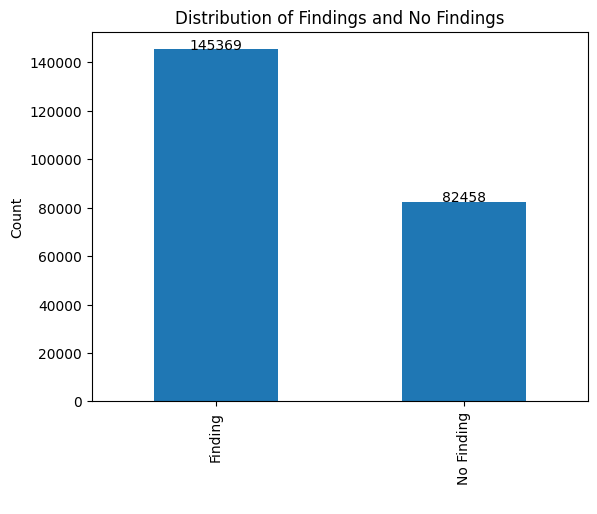

In [19]:
# Count the number of No Finding and Findings
findings_count = only_findings_df['Findings'].value_counts()

# Create a bar chart
ax = findings_count.plot(kind='bar', title='Distribution of Findings and No Findings')
ax.set_xlabel(' ')
ax.set_ylabel('Count')

# Add the true count as text on top of each bar
for i, v in enumerate(findings_count.values):
    ax.text(i, v+100, str(v), ha='center', fontsize=10)

# Set the x-tick labels to "No Finding" and "Finding"
ax.set_xticklabels(['Finding', 'No Finding'])

plt.show()


In [10]:
# Count the number of symptoms
# For each row, count the number of 1's in the columns representing symptoms
symptom_counts = all_findings_df.iloc[:, 1:-1].apply(lambda x: sum(x == 1), axis=1)

# Count the number of rows for each count of symptoms
count_table = symptom_counts.value_counts()

# Initialize an empty list to hold the output
symptom_list_count = []

# Append each row of the count table to the output list as a string
# Each row represents the number of rows with a certain number of symptoms
for i in range(1, max(count_table.index)+1):
    symptom_list_count.append(f"{i} Symptom: {count_table.get(i, 0)}")

# Convert the output list to a dataframe
symptom_list_count_df = pd.DataFrame(symptom_list_count)

# Display the dataframe
symptom_list_count_df

# Create a LaTeX table out of the dataframe
print(symptom_list_count_df.to_latex(index=False, header=False))

# Save the LaTeX table to a file for use in the thesis


\begin{tabular}{l}
\toprule
\midrule
1 Symptom: 52842 \\
2 Symptom: 42506 \\
3 Symptom: 29453 \\
4 Symptom: 16730 \\
5 Symptom: 6419 \\
6 Symptom: 1642 \\
7 Symptom: 273 \\
8 Symptom: 29 \\
9 Symptom: 2 \\
\bottomrule
\end{tabular}



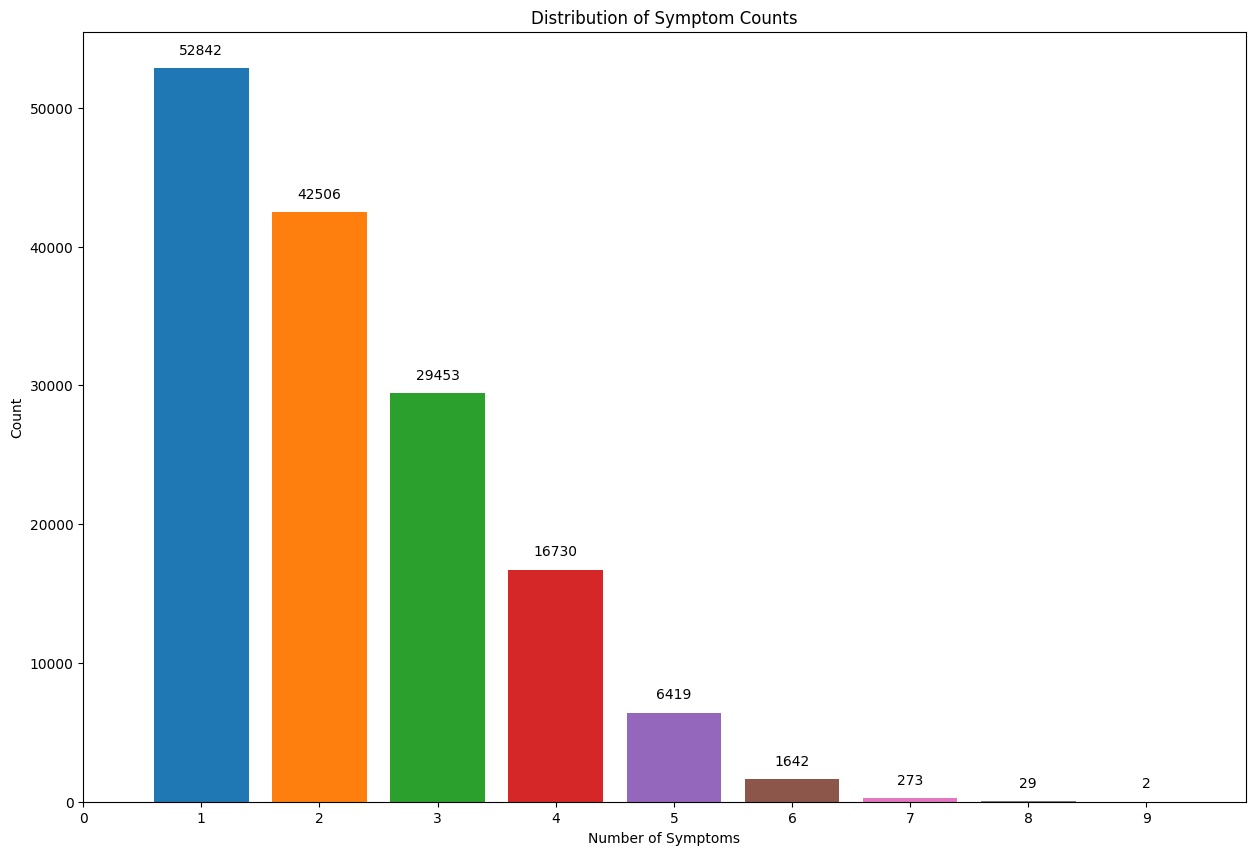

In [20]:
count_table = count_table.drop(count_table.index[0])
#create a bar chart of the symptom count
plt.figure(figsize=(15, 10))
plt.bar(count_table.index, count_table.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])
plt.xlabel('Number of Symptoms')
plt.ylabel('Count')
plt.title('Distribution of Symptom Counts')
plt.xticks(range(0, max(count_table.index)+1))
# Add the true count as text on top of each bar
for i, v in enumerate(count_table.values):
    plt.text(count_table.index[i], v+1000, str(v), ha='center', fontsize=10)
plt.show()


In [13]:
# Sum the values in each column
column_sums = all_findings_df.iloc[:, 1:].sum()

# Print the column sums
for i in range(len(column_sums)):
    print(f"{all_findings_df.columns[i+1]}: {column_sums[i]}")


Atelectasis: 46000
Cardiomegaly: 39112
Consolidation: 10640
Edema: 26610
Enlarged Cardiomediastinum: 7040
Fracture: 3782
Lung Lesion: 6175
Lung Opacity: 51347
Pleural Effusion: 53344
Pleural Other: 1998
Pneumonia: 15919
Pneumothorax: 9332
Support Devices: 65942
No Finding: 82458


In [14]:
all_findings_df

,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,No Finding
0,50002405,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,50003651,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,50006246,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,50008565,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,50008601,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,59992045,0,0,0,0,0,0,0,0,1,0,0,0,1,0
227823,59995675,1,1,0,0,0,0,0,0,1,0,0,0,1,0
227824,59995853,0,0,0,0,0,0,0,0,0,0,0,0,0,1
227825,59997822,0,1,0,1,0,0,0,0,1,0,0,0,1,0


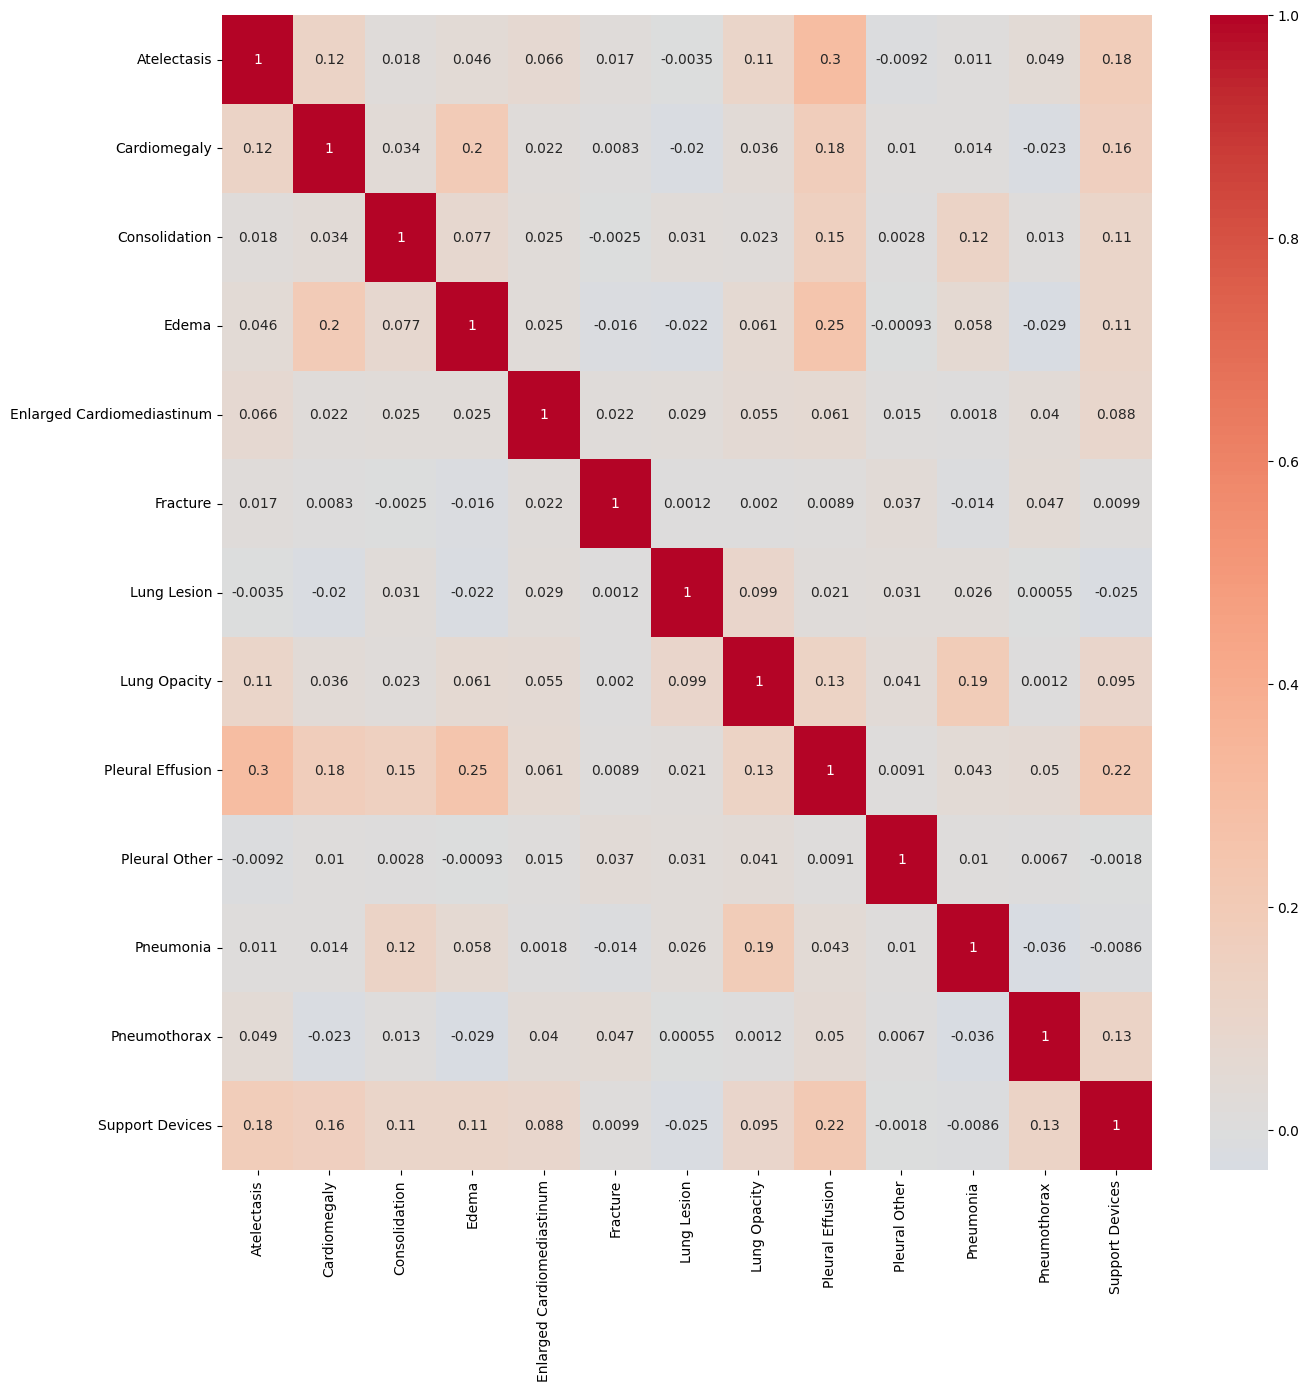

In [15]:
# These are the columns that contain information about the different medical conditions
columns_of_interest = all_findings_df.columns[1:-1]

# This matrix shows how strongly each pair of medical conditions is correlated with each other
corr_matrix = all_findings_df[columns_of_interest].corr()

# Create a figure and axis object for the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the correlation matrix as a heatmap
# The heatmap shows the correlation values as colors, with red indicating positive correlation and blue indicating negative correlation
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, center=0, ax=ax)

# Show the plot
plt.show()


In [16]:
#The Latex table is created by printing the correlation matrix as a Latex table
print(corr_matrix.to_latex(index=True, header=True))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 & Atelectasis & Cardiomegaly & Consolidation & Edema & Enlarged Cardiomediastinum & Fracture & Lung Lesion & Lung Opacity & Pleural Effusion & Pleural Other & Pneumonia & Pneumothorax & Support Devices \\
\midrule
Atelectasis & 1.000000 & 0.121348 & 0.017604 & 0.045763 & 0.065624 & 0.016978 & -0.003487 & 0.107756 & 0.304083 & -0.009196 & 0.010930 & 0.048592 & 0.183744 \\
Cardiomegaly & 0.121348 & 1.000000 & 0.034113 & 0.197972 & 0.021955 & 0.008265 & -0.019861 & 0.036328 & 0.180101 & 0.010112 & 0.014342 & -0.023142 & 0.164738 \\
Consolidation & 0.017604 & 0.034113 & 1.000000 & 0.077026 & 0.025030 & -0.002544 & 0.030696 & 0.023100 & 0.154286 & 0.002831 & 0.122362 & 0.012508 & 0.108501 \\
Edema & 0.045763 & 0.197972 & 0.077026 & 1.000000 & 0.025408 & -0.015909 & -0.022069 & 0.061317 & 0.245156 & -0.000933 & 0.057878 & -0.028888 & 0.107220 \\
Enlarged Cardiomediastinum & 0.065624 & 0.021955 & 0.025030 & 0.025408 & 1.000000 & 0.021864 & 0.029395 & 

In [17]:
# Get a statistical summary of the merged_data DataFrame
summary = all_findings_df.describe()

# Print the summary
summary

,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,No Finding
count,2.278270e+05,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000,227827.000000
mean,5.500453e+07,0.201908,0.171674,0.046702,0.116799,0.030901,0.016600,0.027104,0.225377,0.234143,0.008770,0.069873,0.040961,0.289439,0.361933
std,2.887577e+06,0.401424,0.377098,0.211001,0.321182,0.173049,0.127769,0.162387,0.417831,0.423463,0.093236,0.254934,0.198200,0.453503,0.480560
min,5.000001e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.250058e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.501075e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.750608e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,5.999992e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the function to compute t-SNE in parallel
def compute_tsne(X):
    tsne = TSNE(n_components=2, n_jobs=-1)
    return tsne.fit_transform(X)

# Drop columns with NaN values and fill NaN with 0
merged_data_ = merged_data.fillna(0)

# Separate features and target
X = merged_data_.drop(columns=['id', 'No Finding'])
y = merged_data_['No Finding']

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Compute t-SNE in parallel with tqdm progress bar
X_tsne = Parallel(n_jobs=-1)(delayed(compute_tsne)(X) for X in tqdm(np.array_split(X, 100)))

# Concatenate the t-SNE results
X_tsne = np.concatenate(X_tsne, axis=0)e

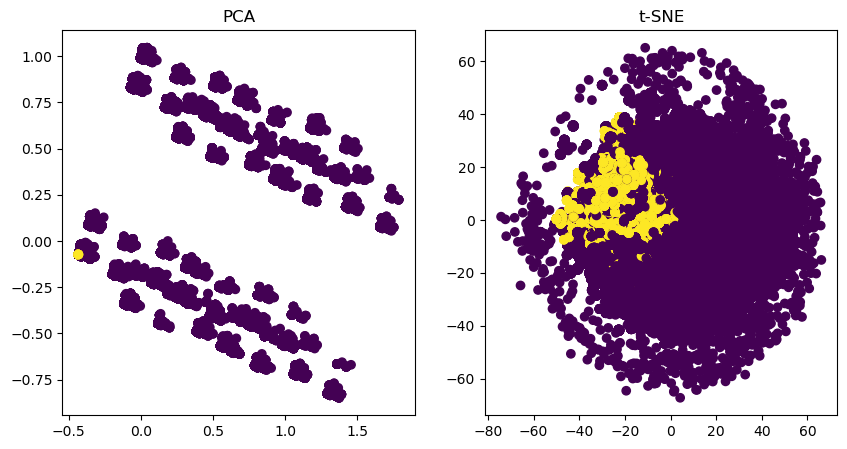

In [ ]:
# Define the color map
cmap = plt.cm.get_cmap('tab20')

# Visualize results using scatter plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap)
axs[0].set_title('PCA')
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap)
axs[1].set_title('t-SNE')
plt.show()

\begin{tabular}{lr}
\toprule
 & Frequency \\
Finding &  \\
\midrule
Atelectasis & 46000 \\
Cardiomegaly & 39112 \\
Consolidation & 10640 \\
Edema & 26610 \\
Enlarged Cardiomediastinum & 7040 \\
Fracture & 3782 \\
Lung Lesion & 6175 \\
Lung Opacity & 51347 \\
Pleural Effusion & 53344 \\
Pleural Other & 1998 \\
Pneumonia & 15919 \\
Pneumothorax & 9332 \\
Support Devices & 65942 \\
No Finding & 82458 \\
\bottomrule
\end{tabular}



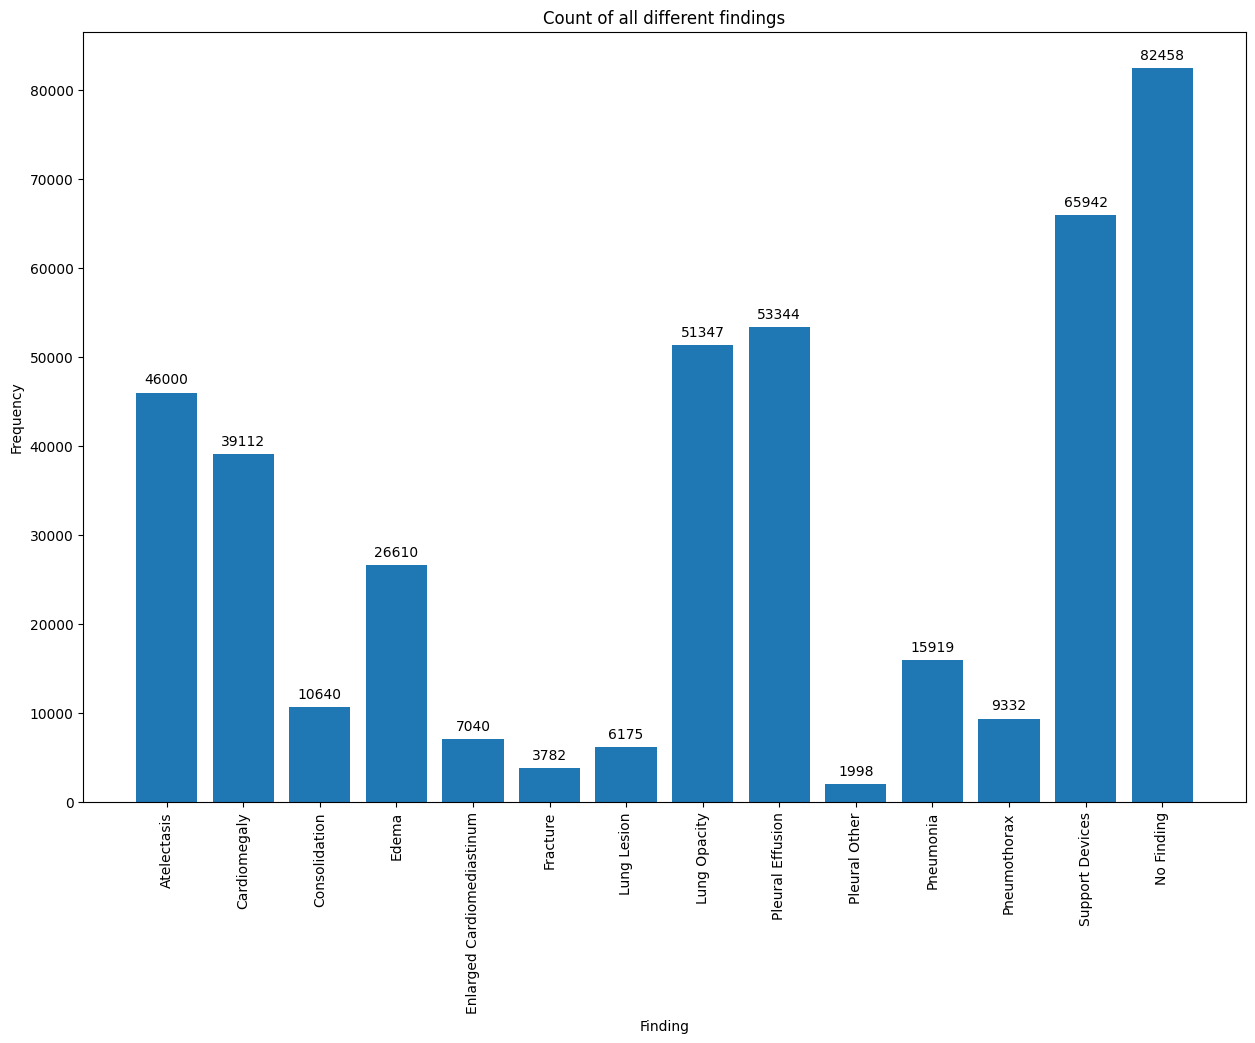

In [ ]:
# Create a LaTeX table from the finding_counts series
finding_counts_df = pd.DataFrame(finding_counts)
finding_counts_df.columns = ['Frequency']
finding_counts_df.index.name = 'Finding'
latex_table = finding_counts_df.to_latex()

# Print the LaTeX table
print(latex_table)
# Set the figure size
plt.figure(figsize=(15, 10))

# bar plot if the frequency of each finding in the dataset
finding_counts = merged_data.iloc[:, 1:].sum()
plt.bar(finding_counts.index, finding_counts.values)
plt.xticks(rotation=90)

plt.xlabel("Finding")
plt.ylabel("Frequency")

# Add the true count as text on top of each bar
for i, v in enumerate(finding_counts.values):
    plt.text(i, v+1000, str(v), ha='center', fontsize=10)

plt.title("Count of all different findings")
plt.show()


In [ ]:
# Count the number of 1's in each row
symptom_counts = all_findings_df.iloc[:, 1:-1].apply(lambda x: sum(x == 1), axis=1)

# Count the number of rows for each count
count_table = symptom_counts.value_counts()

# Initialize an empty list to hold the output
symtom_list_count = []

# Append each row of the count table to the output list as a string
for i in range(1, max(count_table.index)+1):
    symtom_list_count.append(f"{i} Symptom: {count_table.get(i, 0)}")

# output_list to dataframe
symtom_list_count_df = pd.DataFrame(symtom_list_count)

# Print the dataframe as a LaTeX table
print(symtom_list_count_df.to_latex(index=False, header=False))


\begin{tabular}{l}
\toprule
\midrule
1 Symptom: 52842 \\
2 Symptom: 42506 \\
3 Symptom: 29453 \\
4 Symptom: 16730 \\
5 Symptom: 6419 \\
6 Symptom: 1642 \\
7 Symptom: 273 \\
8 Symptom: 29 \\
9 Symptom: 2 \\
\bottomrule
\end{tabular}



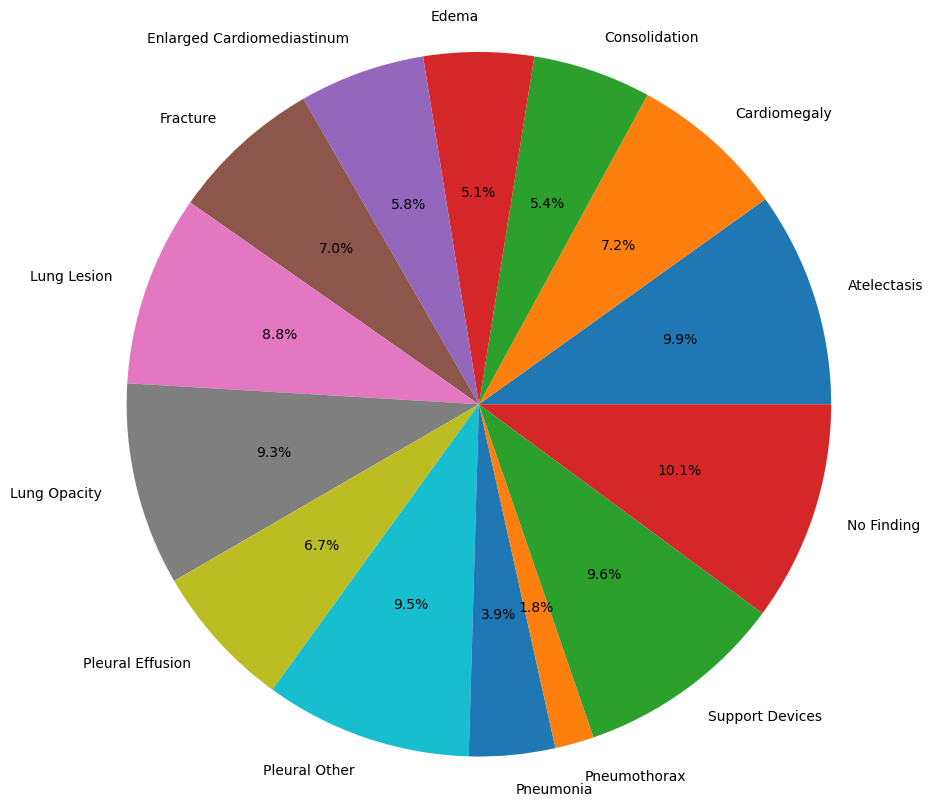

In [ ]:
#pie chart of the frequency of each finding in the dataset
finding_counts = merged_data.iloc[:, 1:].mean()
#size of the figure is 10x10 inches
plt.figure(figsize=(10, 10))
plt.pie(finding_counts.values, labels=finding_counts.index, autopct="%1.1f%%")
plt.axis("equal")
plt.show()

In [ ]:
jpg_records = pd.read_csv("/data/csv/jpg_path_study_records.csv")
jpg_records

,subject_id_x,study_id,dicom_id,dicom_path,study_path,jpg_path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,files/p10/p10000032/s50414267.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,files/p10/p10000032/s50414267.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,files/p10/p10000032/s53189527.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,files/p10/p10000032/s53189527.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,files/p10/p10000032/s53911762.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
...,...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,files/p19/p19999733/s57132437.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,files/p19/p19999733/s57132437.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,files/p19/p19999987/s55368167.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,files/p19/p19999987/s58621812.txt,/system/user/publicdata/MIMIC_CXR/hageneder/JP...


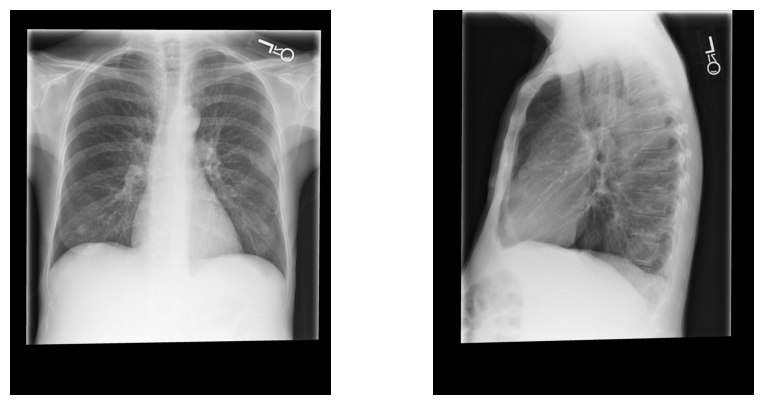

In [ ]:


# Define the study_id and get the jpg_paths
study_id = "50414267"
jpg_paths = jpg_records.loc[jpg_records["study_id"] == int(study_id), "jpg_path"].values[:2]

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the first image in the first subplot
img1 = mpimg.imread(jpg_paths[0])
axs[0].imshow(img1, cmap='gray')
axs[0].axis('off')

# Plot the second image in the second subplot
img2 = mpimg.imread(jpg_paths[1])
axs[1].imshow(img2, cmap='gray')
axs[1].axis('off')

# Show the plot
plt.show()
